In [1]:
import pandas as pd
import numpy as np
import os

import networkx as nx
import re
import matplotlib.pyplot as plt

In [2]:
# importing data

edges = pd.read_csv('data/edges.csv')
nodes = pd.read_csv('data/nodes.csv')
hero_edges = pd.read_csv('data/hero-network.csv')
datasets = [edges, nodes, hero_edges]

In [3]:
# preprocessing
def strip_rightend(string):
    string = string.strip().rstrip('/')

    if string =='SPIDER-MAN/PETER PARKER':
        string = 'SPIDER-MAN/PETER PAR'
    elif string == 'SPIDER-MAN/PETER PARKERKER':
        string = 'SPIDER-MAN/PETER PAR'

    return string

In [4]:
for ds in datasets:
    ds.dropna(inplace=True)
    for col in ds.columns:
        ds[col] = ds[col].apply(lambda row: strip_rightend(row))

In [5]:
hero_edges_arr = np.array(hero_edges)
hero_edges_arr.shape

(574467, 2)

In [6]:
idx_self = np.where(hero_edges_arr[:,0] == hero_edges_arr[:,1])
idx_self
# we check on a sample
hero_edges.iloc[8889]

hero1    MISS AMERICA/MADELIN
hero2    MISS AMERICA/MADELIN
Name: 8889, dtype: object

In [7]:
hero_edges_arr = np.delete(hero_edges_arr, idx_self, axis = 0) # delete the self referring rows by their index
print(hero_edges_arr.shape) # 574467 down to 572235
heroes_df = pd.DataFrame(hero_edges_arr) # ! new df 
heroes_df.columns = ['hero1', 'hero2']

(572235, 2)


creating the hero network graph 

In [313]:
heroes = nx.from_pandas_edgelist(heroes_df, 'hero1', 'hero2', create_using=nx.Graph)

In [314]:
node_count = heroes_df.groupby(['hero1','hero2'])['hero1','hero2'].size()#.apply(lambda row: print(row))

fl = np.power(np.array(list(map(float, node_count.values))), -1)

weights = dict( list(zip (node_count.index, fl) ) )

/var/folders/c0/1q90pl8n3k50gnjpfmzf_lzh0000gn/T/ipykernel_24964/1918835698.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  node_count = heroes_df.groupby(['hero1','hero2'])['hero1','hero2'].size()#.apply(lambda row: print(row))


In [315]:
node_tuple_weight = {}
for e in heroes.edges: # 
    try:
        weight = weights[(e[0], e[1])]
    except:
        weight = weights[(e[1], e[0])]

    node_tuple_weight[(e[0], e[1])] = weight

In [316]:
nx.set_edge_attributes(heroes, values = node_tuple_weight, name = 'weight')

creating the comics (& corresponding heroes) graph

In [13]:
node_data = list(zip(nodes.node, [{'tp':t}for t in nodes.type]))
edge_data = list(zip(edges.hero, edges.comic))

In [14]:
# modify edge data to be only included if nodes also in node_data

edge_arr = np.array(edge_data)
print(edge_arr.shape)
node_list = list(nodes.node)

tbd = []

for i in range(len(edge_arr)):
    a, b = edge_arr[i,0], edge_arr[i,1]
    if a not in node_list or b not in node_list:
        tbd.append(i)

edge_arr = np.delete(edge_arr, tbd, axis = 0)
print(edge_arr.shape)

edges_cleaned = pd.DataFrame(edge_arr)
edges_cleaned.columns = ['hero', 'comic'] # needed to establish top hero
# edge_data = [(e[0], e[1])for e in edge_arr.tolist()]
edge_data = list(zip(edges_cleaned.hero, edges_cleaned.comic))

(96104, 2)
(96104, 2)


In [15]:
comics = nx.Graph()
comics.add_nodes_from(node_data)
comics.add_edges_from(edge_data)

In [189]:
# making list of top_n sorted heroes
ls = edges_cleaned.groupby(by = 'hero')['comic'].size().sort_values(ascending=False)
top_n_heroes = np.array(list(zip(ls.index, ls.values)) )

## Functionality 5 - Extracting Communities

We extract communities from a network of top N heroes. The functionality is built on a Girvan Nevman Algorithm as seen in [this article](https://www.analyticsvidhya.com/blog/2020/04/community-detection-graphs-networks/). <br/>
When testing the code we restrict the computation of edge betweenness centrality to a degree of 50. Trading off accuracy for computational time.

functionality5 calls the functions make_topnhero_graph, divide_graph and ebc.

In [336]:
# TODO: delete from func 3 or here, also see if we all want to use one

def make_topnhero_graph(graph, N, neighbors = False):
    n_heroes = top_n_heroes[:N, 0]

    rel_nodes = list(n_heroes)
    if neighbors:
        for hero in n_heroes:
            [rel_nodes.append(n) for n in graph.neighbors(hero) if n not in rel_nodes]
        
    sub_graph = graph.subgraph(rel_nodes)

    return sub_graph

In [318]:
'''
ebc() returns the graph edge with highest betweenness centrality
'''

def ebc(graph, degree): # degree < nr_nodes, makes function feasible
    ebc_dict = nx.edge_betweenness_centrality(graph, k=degree)
    ebc_l = [k for k, v in sorted(ebc_dict.items(), key=lambda item: item[1], reverse=True)] # sort edges by values of betweenness centrality
    return ebc_l[0] # return edge with highest betweenness centrality

In [337]:
''' 
called by main function5, constructs nr_comm communities from original graph
returns nodes for communities, list of removed_edges and split graph
'''

def divide_graph(o_graph, nr_comm = 2, degree = 10): # takes subgraph of top_n heroes, nr of commu
    graph = o_graph.copy()
    sg_count = nx.number_connected_components(graph)
    if sg_count > nr_comm:
        print(f'number of initial unconnected components{sg_count} is higher than goal {nr_comm}')
    removed_edges = []

    while(sg_count < nr_comm):
        highest_ebc = ebc(graph, degree)
        removed_edges.append(highest_ebc)
        graph.remove_edge(highest_ebc[0], highest_ebc[1])

        sg_count = nx.number_connected_components(graph)

    rest = nx.connected_components(graph)

    return rest, removed_edges, graph

In [387]:
'''
function takes original graph, N number of top_n heroes to consider, two heroes, nr of communities to generate, max degree of betweenness centrality of edges to calculate
    generates sub_graph of top N heroes
    passes sub_graph to function divide_graph() which returns:
        nodes for each community
        list of removed edges
        the cut graph
    prints: nr_of edges removed and communities of hero1 & hero2
    returns: (same return values as divide_graph)
         copy of dictionary with values being lists of nodes
         list of removed edges
         the cut graph
'''
def functionality5(graph, N, hero1, hero2, nr_comm = 2, degree = 10):
    sub_heroes = make_topnhero_graph(graph, N, False) 
    rest, removed_edges, cut_graph = divide_graph(sub_heroes, nr_comm, degree)
    
    print(f'Number of edges removed to form {nr_comm} communities: {len(removed_edges)}\n')
    
    rest_copy = [c for c in rest] # copy returned list into rest_copy
    ass_comm = [] 
    i = 0
    for co in rest_copy: # loop through communities, append community of hero1&hero2
        if hero1 in co:
            ass_comm.append((hero1, i))
        if hero2 in co:
            ass_comm.append((hero2, i))
        i+=1
        
    print(f'{hero1} and {hero2} are assigned to {len(ass_comm)} communities') # print the number of communities of hero1&hero2 belong to

    return rest_copy, removed_edges, cut_graph

In [376]:
ass_comm = []
hero1 = 'CAPTAIN AMERICA'
hero2 = 'Ironman'

i = 0
for c in rest:
    if hero1 in c:
        ass_comm.append((hero1, i))
    if hero2 in c:
        ass_comm.append((hero2, i))
    i+=1
ass_comm

[('CAPTAIN AMERICA', 0)]

In [375]:
%%time
# call function5 on heroes, N=50, 'Captain America', 'Ironman/TONY STARK'
# to extract 4 communities while calculating edge betweenness centrality to degree=50
rest, removed_edges, cut_graph = functionality5(heroes, 50, 'Captain America', 'Ironman/TONY STARK', 4, 50)

Number of edges removed to form 4 communities: 124

[]
Captain America and Ironman/TONY STARK are assigned to 0 communities
CPU times: user 2.76 s, sys: 28.7 ms, total: 2.79 s
Wall time: 2.91 s


### Visualization

In [384]:
N = 50
hero1 = 'Captain America'
hero2 =  'Ironman/TONY STARK'
n_comm = 4

hero_sel = top_n_heroes[:N, 0]
#comm_assignment = {i: n for i,n in enumerate(rest)}
comm_assignment = [ n for i,n in enumerate(rest)]

df = pd.DataFrame(comm_assignment).T
df.columns = ['community '+str(i) for i in df.columns]
df.head(8)

,community 0,community 1,community 2,community 3
0,BLACK PANTHER/T'CHAL,CANNONBALL II/SAM GU,SHADOWCAT/KATHERINE,PUNISHER II/FRANK CA
1,"WATSON-PARKER, MARY",None,None,None
2,NIGHTCRAWLER/KURT WA,None,None,None
3,"JONES, RICHARD MILHO",None,None,None
4,ANGEL/WARREN KENNETH,None,None,None
5,PROFESSOR X/CHARLES,None,None,None
6,HAWK,None,None,None
7,QUICKSILVER/PIETRO M,None,None,None


In [378]:
# setting parameters for plotting of graph

sub_heroes = make_topnhero_graph(heroes, N, False)
comm_ass = {h:i for i, c in enumerate(rest) for h in c} # dictionary of node : community_index 

edge_cols = ['red' if e in removed_edges else 'grey' for e in sub_heroes.edges()] # default edge color is grey, the edges that are removed are red
edge_width = [1 if e in removed_edges else 0.05 for e in sub_heroes.edges()]# width of to be removed edges is highlited

node_colors =[comm_ass[node] for node in sub_heroes.nodes()] # nodes of same communities share color

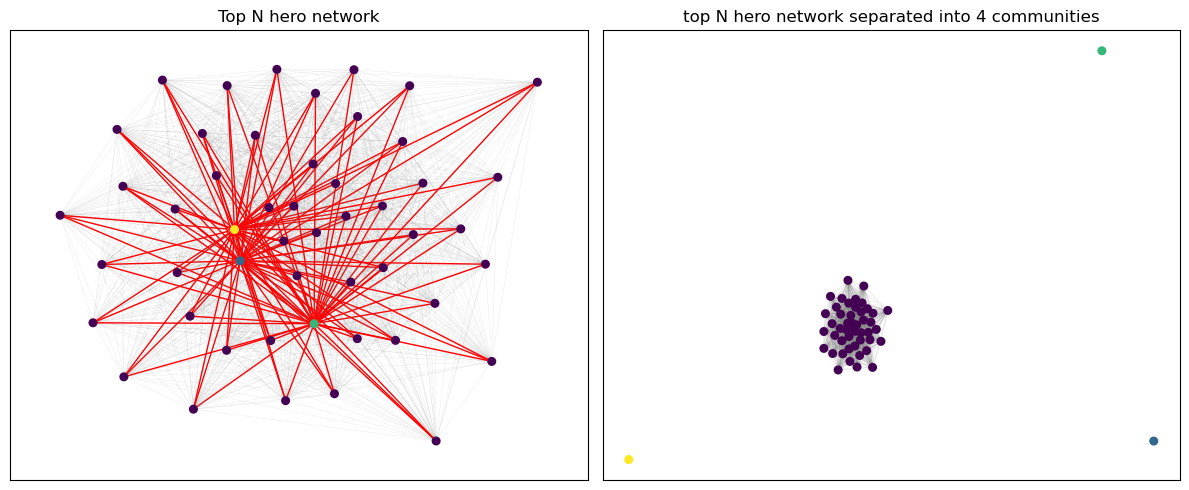

In [386]:
fig, ax = plt.subplots(1,2, figsize = (12,5))
pos = nx.spring_layout(sub_heroes)
nx.draw_networkx(sub_heroes, pos, node_size=30, node_color=node_colors, edge_color=edge_cols, width=edge_width, with_labels=False, ax = ax[0])
ax[0].set_title('Top N hero network')

#sub_heroes_cut = sub_heroes.copy()
#sub_heroes_cut.remove_edges_from(removed_edges)
pos = nx.spring_layout(cut_graph)
nx.draw_networkx(cut_graph, pos, node_size=30, node_color=node_colors, edge_color='grey', width=0.1, with_labels=False, ax = ax[1])

ax[1].set_title(f'top N hero network separated into {n_comm} communities')
fig.tight_layout()

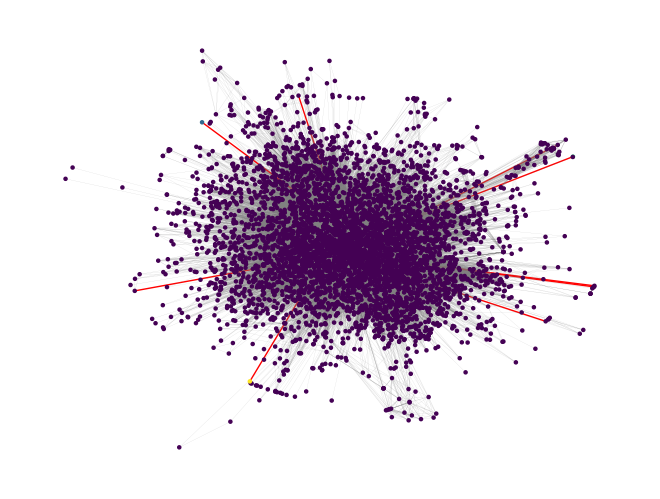

In [261]:

nx.draw(sub_heroes,node_size=5, node_color=node_colors, edge_color=edge_cols, width=edge_width, with_labels=False)